In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
path = 'Funda_dataset_cleaned.csv'

data = pd.read_csv(path)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9884 entries, 0 to 9883
Columns: 112 entries, Aangeboden sinds to Soort woonhuis
dtypes: int64(104), object(8)
memory usage: 8.4+ MB


In [ ]:
data.shape

(9884, 112)

In [ ]:
print(data.dtypes.unique())

[dtype('O') dtype('int64')]


In [4]:

num_duplicates = data.duplicated().sum()
print("Number of duplicate rows:", num_duplicates)


data.drop_duplicates(inplace=True)

Number of duplicate rows: 13


In [5]:
data.drop(['Aangeboden sinds', 'Verkoopdatum'], axis=1, inplace=True)

In [6]:
data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs')

<ipython-input-6-855a70a2f4ab>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs')


Woonruimte in m2                            0.680477
Inhoud in m3                                0.587934
Bathrooms                                   0.474886
Vraagprijs per m2                           0.470889
Aantal kamers                               0.403485
                                              ...   
Schuur/berging_Box                         -0.053630
Isolatie_Geenisolatie                      -0.061635
Voorzieningen_Tvkabel                      -0.077961
Schuur/berging_Vrijstaandestenen berging   -0.094548
Verwarming_Blokverwarming                  -0.136348
Name: Laatste vraagprijs, Length: 103, dtype: float64

In [7]:
cor=data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs')

<ipython-input-7-1875e60eb14e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor=data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs')


<ipython-input-8-1bfcd880fecc>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()
<ipython-input-8-1bfcd880fecc>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.bar(x=list(data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs').index), height=list(data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs').values), color='teal')
<ipython-input-8-1bfcd880fecc>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to

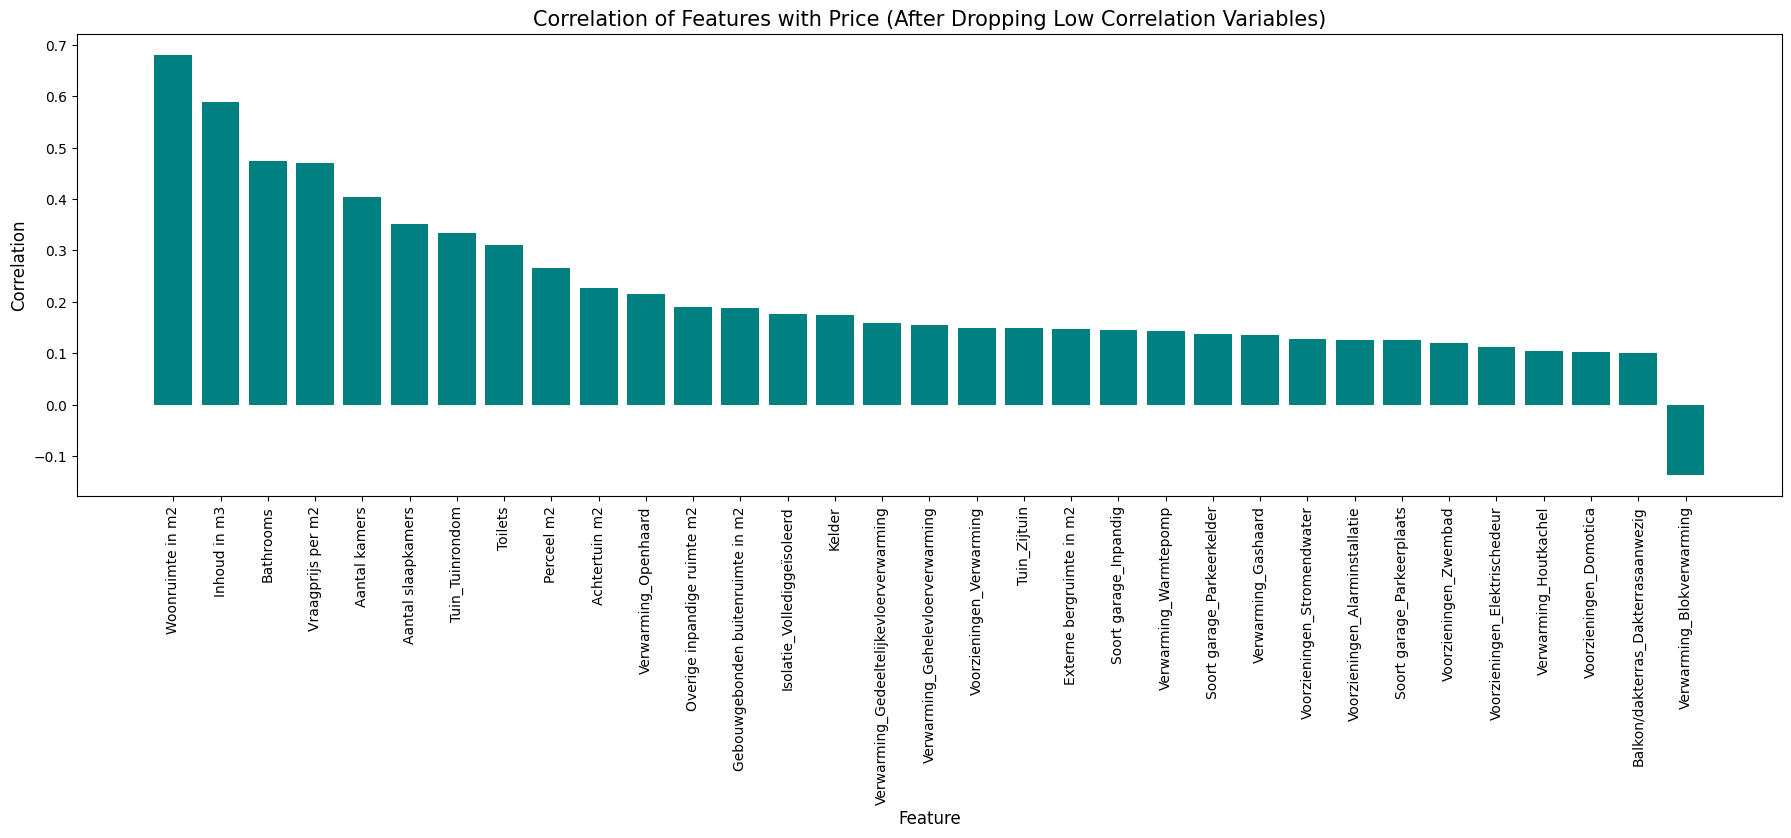

In [8]:
corr_matrix = data.corr()
drop_list = corr_matrix[corr_matrix['Laatste vraagprijs'].abs() < 0.1].index.to_list()

data = data.drop(drop_list, axis=1)


plt.figure(figsize=(22,6))
plt.bar(x=list(data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs').index), height=list(data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs').values), color='teal')
plt.xticks(rotation=90)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.title('Correlation of Features with Price (After Dropping Low Correlation Variables)', fontsize=15)
plt.show()

In [ ]:
data.shape

(9871, 40)

# **Split the Target variable from the input variables**

In [9]:
X = data.drop('Laatste vraagprijs',axis=1)
y = data['Laatste vraagprijs']

X.head()
X.describe()
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9871 entries, 0 to 9883
Data columns (total 39 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   Status                                   9871 non-null   object
 1   Soort bouw                               9871 non-null   object
 2   Aantal kamers                            9871 non-null   int64 
 3   Energielabel                             9871 non-null   object
 4   Overige inpandige ruimte m2              9871 non-null   int64 
 5   Perceel m2                               9871 non-null   int64 
 6   Achtertuin m2                            9871 non-null   int64 
 7   Aantal dagen tot verkoop                 9871 non-null   object
 8   Vraagprijs per m2                        9871 non-null   int64 
 9   Woonruimte in m2                         9871 non-null   int64 
 10  Gebouwgebonden buitenruimte in m2        9871 non-null   int

In [10]:
# Split the data into training and testing sets
X_train_full, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# **Transform Categorical variables by encoding**

In [11]:
from sklearn.preprocessing import StandardScaler

# transformers
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Select categorical columns with fewer than 1000 unique values
categorical_col = [col for col in X_train_full.columns if X_train_full[col].dtype == 'O' and X_train_full[col].nunique() < 1000]
# Print the selected categorical columns
print("Categorical Columns:")
print(categorical_col)

# Select numerical columns
numerical_col = [col for col in X_train_full.columns if X_train_full[col].dtype in ['float64', 'int64']]
# Print the selected numerical columns
print("Numerical Columns:")
print(numerical_col)

# Combine selected categorical and numerical columns
my_cols = categorical_col + numerical_col
# Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_col),
    ('cat', categorical_transformer, categorical_col)])


eval_set_pipe = Pipeline([
    ('preprocessor', preprocessor)
])

Categorical Columns:
['Status', 'Soort bouw', 'Energielabel', 'Aantal dagen tot verkoop', 'Soort dak', 'Soort woonhuis']
Numerical Columns:
['Aantal kamers', 'Overige inpandige ruimte m2', 'Perceel m2', 'Achtertuin m2', 'Vraagprijs per m2', 'Woonruimte in m2', 'Gebouwgebonden buitenruimte in m2', 'Externe bergruimte in m2', 'Inhoud in m3', 'Aantal slaapkamers', 'Bathrooms', 'Toilets', 'Kelder', 'Voorzieningen_Domotica', 'Voorzieningen_Zwembad', 'Voorzieningen_Verwarming', 'Voorzieningen_Stromendwater', 'Voorzieningen_Elektrischedeur', 'Voorzieningen_Alarminstallatie', 'Isolatie_Vollediggeïsoleerd', 'Verwarming_Gedeeltelijkevloerverwarming', 'Verwarming_Warmtepomp', 'Verwarming_Gehelevloerverwarming', 'Verwarming_Blokverwarming', 'Verwarming_Gashaard', 'Verwarming_Openhaard', 'Verwarming_Houtkachel', 'Balkon/dakterras_Dakterrasaanwezig', 'Tuin_Zijtuin', 'Tuin_Tuinrondom', 'Soort garage_Parkeerplaats', 'Soort garage_Inpandig', 'Soort garage_Parkeerkelder']


In [12]:
# from sklearn.preprocessing import RobustScaler
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import OneHotEncoder


# numerical_transformer = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', RobustScaler())
# ])

# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# # Select categorical columns with fewer than 1000 unique values
# categorical_col = [col for col in X_train_full.columns if X_train_full[col].dtype == 'O' and X_train_full[col].nunique() < 1000]
# # Print the selected categorical columns
# print("Categorical Columns:")
# print(categorical_col)

# # Select numerical columns
# numerical_col = [col for col in X_train_full.columns if X_train_full[col].dtype in ['float64', 'int64']]
# # Print the selected numerical columns
# print("Numerical Columns:")
# print(numerical_col)

# # Combine selected categorical and numerical columns
# my_cols = categorical_col + numerical_col
# # Create the preprocessor using ColumnTransformer
# preprocessor = ColumnTransformer(transformers=[
#     ('num', numerical_transformer, numerical_col),
#     ('cat', categorical_transformer, categorical_col)
# ])


# eval_set_pipe = Pipeline([
#     ('preprocessor', preprocessor)
# ])




Categorical Columns:
['Status', 'Soort bouw', 'Energielabel', 'Aantal dagen tot verkoop', 'Soort dak', 'Soort woonhuis']
Numerical Columns:
['Aantal kamers', 'Overige inpandige ruimte m2', 'Perceel m2', 'Achtertuin m2', 'Vraagprijs per m2', 'Woonruimte in m2', 'Gebouwgebonden buitenruimte in m2', 'Externe bergruimte in m2', 'Inhoud in m3', 'Aantal slaapkamers', 'Bathrooms', 'Toilets', 'Kelder', 'Voorzieningen_Domotica', 'Voorzieningen_Zwembad', 'Voorzieningen_Verwarming', 'Voorzieningen_Stromendwater', 'Voorzieningen_Elektrischedeur', 'Voorzieningen_Alarminstallatie', 'Isolatie_Vollediggeïsoleerd', 'Verwarming_Gedeeltelijkevloerverwarming', 'Verwarming_Warmtepomp', 'Verwarming_Gehelevloerverwarming', 'Verwarming_Blokverwarming', 'Verwarming_Gashaard', 'Verwarming_Openhaard', 'Verwarming_Houtkachel', 'Balkon/dakterras_Dakterrasaanwezig', 'Tuin_Zijtuin', 'Tuin_Tuinrondom', 'Soort garage_Parkeerplaats', 'Soort garage_Inpandig', 'Soort garage_Parkeerkelder']


# **Define the eval_set_pipe with the preprocessor**

In [13]:
# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_col),
 ('cat', categorical_transformer, categorical_col)])

eval_set_pipe = Pipeline([
    ('preprocessor', preprocessor)
])

# **Transform X_train and X_test without eval_set_pipe**

In [14]:

# Transform X_train and X_test without eval_set_pipe
X_train_eval = X_train_full[my_cols]
X_test_eval = X_test[my_cols]


# Convert the original data to DataFrames with the original index (no transformation)
X_train_eval_df = pd.DataFrame(X_train_eval, index=X_train_full.index)
X_test_eval_df = pd.DataFrame(X_test_eval, index=X_test.index)
X_test_eval_df.head()

,Status,Soort bouw,Energielabel,Aantal dagen tot verkoop,Soort dak,Soort woonhuis,Aantal kamers,Overige inpandige ruimte m2,Perceel m2,Achtertuin m2,...,Verwarming_Blokverwarming,Verwarming_Gashaard,Verwarming_Openhaard,Verwarming_Houtkachel,Balkon/dakterras_Dakterrasaanwezig,Tuin_Zijtuin,Tuin_Tuinrondom,Soort garage_Parkeerplaats,Soort garage_Inpandig,Soort garage_Parkeerkelder
6209,Verkocht,Bestaande bouw,B,29 days,Zadeldak bedekt met pannen,"Eengezinswoning, 2-onder-1-kapwoning",5,12,430,200,...,0,0,0,0,0,0,0,0,0,0
343,Verkocht,Nieuwbouw,None,113 days,Plat dak bedekt met bitumineuze dakbedekking,"Herenhuis, 2-onder-1-kapwoning",2,0,48,0,...,0,0,0,0,0,0,0,0,0,0
9788,Verkocht,Bestaande bouw,C,28 days,Plat dak bedekt met bitumineuze dakbedekking,"Eengezinswoning, hoekwoning (hofjeswoning)",6,0,97,0,...,0,0,0,0,0,0,0,0,0,0
3056,Verkocht,Bestaande bouw,B,14 days,Dwarskap bedekt met pannen,"Eengezinswoning, tussenwoning",5,0,122,58,...,0,0,0,0,0,0,0,0,0,0
6513,Verkocht,Bestaande bouw,F,26 days,Plat dak bedekt met bitumineuze dakbedekking,"Eengezinswoning, tussenwoning (hofjeswoning)",3,0,71,0,...,0,0,0,0,0,0,0,0,0,0


# **Transform X_train and X_test using eval_set_pipe**

In [15]:
# Create a DataFrame with column names
column_names_df = pd.DataFrame([X_train_full[my_cols].columns])

# Transform X_train and X_test using eval_set_pipe
X_train_eval = eval_set_pipe.fit_transform(X_train_full[my_cols])
X_test_eval = eval_set_pipe.transform(X_test[my_cols])

# Convert the transformed data to DataFrames with the original index
X_train_eval_df = pd.DataFrame(X_train_eval, index=X_train_full.index)
X_test_eval_df = pd.DataFrame(X_test_eval, index=X_test.index)



X_test_eval_df

,0
6209,"(0, 1)\t1.2\n (0, 2)\t1.6787878787878787\n ..."
343,"(0, 0)\t-3.0\n (0, 2)\t-0.6363636363636364\..."
9788,"(0, 0)\t1.0\n (0, 2)\t-0.3393939393939394\n..."
3056,"(0, 2)\t-0.18787878787878787\n (0, 3)\t0.00..."
6513,"(0, 0)\t-2.0\n (0, 2)\t-0.49696969696969695..."
...,...
6096,"(0, 2)\t-0.1696969696969697\n (0, 3)\t-0.54..."
9380,"(0, 0)\t-2.0\n (0, 2)\t-0.4727272727272727\..."
3450,"(0, 0)\t-1.0\n (0, 2)\t2.109090909090909\n ..."
1970,"(0, 2)\t-0.11515151515151516\n (0, 3)\t-0.5..."


# **XGBoost Parameters**

In [16]:
my_model = XGBRegressor(n_estimators=100, learning_rate=0.2, n_jobs=10)


# **Train the XGBoost model without Tuning**

In [21]:

my_model.fit(X_train_eval, y_train, early_stopping_rounds=60, eval_set=[(X_test_eval, y_test)], verbose=False)

# Make predictions on the test set
y_test_pred = my_model.predict(X_test_eval)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


# **Calculate various accuracy measures**

In [22]:
# Calculate various accuracy measures
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_test_pred)

=
mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100


from sklearn import metrics
print('R2 Score_XGBoost Regression=',metrics.r2_score(y_test,y_test_pred))


print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
#print("Mean Absolute Percentage Error (MAPE):", mape, "%")


R2 Score_XGBoost Regression= 0.9935000819098995
Mean Squared Error (MSE): 281531492.7562038
Root Mean Squared Error (RMSE): 16778.900224871824
Mean Absolute Error (MAE): 6727.437163765822
Mean Absolute Percentage Error (MAPE): 1.471428469539863 %


 predicted vs actual

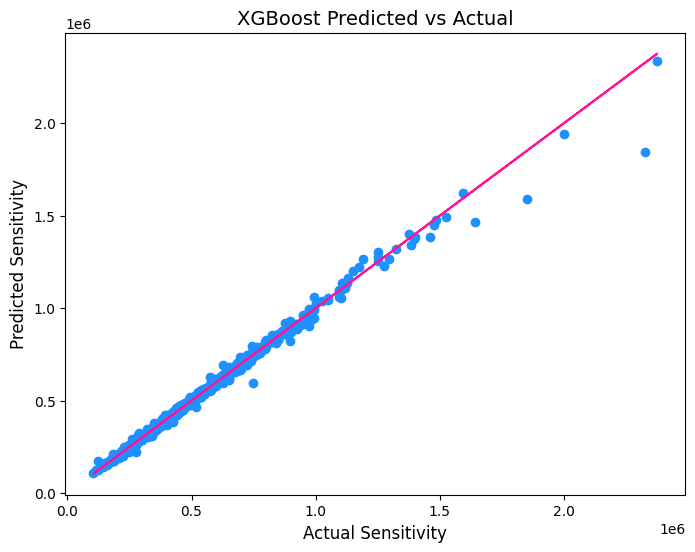

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Create a scatter plot of the actual and predicted sensitivity values
plt.figure(figsize=(8,6))
plt.scatter(x=y_test, y=y_test_pred , color='dodgerblue')

# Add a 45-degree line to represent the perfect prediction
plt.plot(y_test,y_test, color='deeppink')

# Set the axis labels and title
plt.xlabel('Actual Sensitivity',fontsize=12)
plt.ylabel('Predicted Sensitivity',fontsize=12)
plt.title('XGBoost Predicted vs Actual',fontsize=14)

# Display the plot
plt.show()

# **Make Predictions**

In [ ]:
# Transform X_test using eval_set_pipe
X_test_eval = eval_set_pipe.transform(X_test.copy())

# Convert the transformed data to a DataFrame with the original index
X_test_eval_df = pd.DataFrame(X_test_eval, index=X_test.index)

pred_test = my_model.predict(X_test_eval)

predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': pred_test})

print(predictions_df.head())

      Actual     Predicted
6209  369000  393545.81250
343   525000  512617.06250
9788  420000  430200.53125
3056  350000  348146.03125
6513  235000  231334.12500


# **Hyperparameter tuning:**

# **HyperParameters Tuning with Accuracy evaluations**

In [ ]:
import time
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

#log transform
data['Laatste vraagprijs_log'] = np.log1p(data['Laatste vraagprijs'].dropna())


# Define the XGBRegressor model
my_model = XGBRegressor(n_estimators=1500, learning_rate=0.01, n_jobs=6)

# Define the parameter grid for randomized search
param_grid = {
    'n_estimators': range(50, 5000, 100),
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
    'max_depth': range(3, 11),
    'min_child_weight': range(1, 8),
    'gamma': [0, 0.1, 0.5, 1],
}

start_time = time.time()

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(my_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_iter=10)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train_eval, y_train, early_stopping_rounds=20, eval_set=[(X_test_eval, y_test)], verbose=False)

# Get the best model from the RandomizedSearchCV object
best_model = random_search.best_estimator_

# Train
best_model.fit(X_train_eval, y_train, early_stopping_rounds=10, eval_set=[(X_test_eval, y_test)], verbose=False)


training_time = time.time() - start_time

time_left_percentage = (100 - (training_time / (training_time + 1))) * 100


print("Training time:", training_time)
print("Time left in percentage:", time_left_percentage)

# Make predictions on the test set with the best model
y_test_pred = best_model.predict(X_test_eval)


mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_test_pred)
mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100


C:\Users\admin\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in const

C:\Users\admin\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in const

Training time: 334.97934794425964
Time left in percentage: 9900.297637341735


In [ ]:
#metrics
from sklearn import metrics
print('R2 Score_XGBoost Regression=',metrics.r2_score(y_test,y_test_pred))

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape, "%")


R2 Score_XGBoost Regression= 0.9935133592276028
Mean Squared Error (MSE): 280956411.190406
Root Mean Squared Error (RMSE): 16761.75441862832
Mean Absolute Error (MAE): 4562.967183544304
Mean Absolute Percentage Error (MAPE): 0.943949778455007 %


In [ ]:
best_model = random_search.best_estimator_
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.5, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=4050, n_jobs=6,
             num_parallel_tree=None, random_state=None, ...)

In [2]:
!pip install prettytable
from prettytable import PrettyTable

In [23]:
column_names = ["Model", "Hyperparameters"]
data = [
    ["Random Forest (No Tuning)", "{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}"],
    ["Random Forest (Tuned)", "{'max_depth': 60, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 1942}"],
    ["Adaboost (No Tuning)", "{'n_estimators': 1500, 'learning_rate': 0.001, 'loss': 'exponential', 'random_state': 60}"],
    ["Adaboost (Tuned)", "{'random_state': 123, 'n_estimators': 1000, 'loss': 'square', 'learning_rate': 0.1}"],
    ["Tabnet (No Tuning)", "{'n_d': 16, 'n_a': 16, 'n_steps': 5, 'gamma': 1.3, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 2e-2}, 'mask_type': 'entmax', 'scheduler_params': {'max_lr': 0.05, 'steps_per_epoch': 100, 'epochs': 20}}"],
    ["Tabnet (Tuned)", "{'scheduler_params': {'max_lr': 0.01, 'steps_per_epoch': 50, 'epochs': 10}, 'optimizer_params': {'lr': 0.02}, 'n_steps': 3, 'n_d': 8, 'n_a': 8, 'mask_type': 'entmax', 'lambda_sparse': 0.001, 'gamma': 0.1}"],
    ["XGBoost (No Tuning)", "{'n_estimators': 1500, 'learning_rate': 0.01, 'n_jobs': 6}"],
    ["XGBoost (Tuned)", "{'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.5, 'grow_policy': None, 'learning_rate': 0.005, 'max_depth': 8,'min_child_weight': 5, 'n_estimators': 4050, 'n_jobs': 6}"]
]
# Create a PrettyTable object
table = PrettyTable(column_names)

# Add data to the table
for row in data:
    table.add_row(row)

table

Model,Hyperparameters
Random Forest (No Tuning),"{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}"
Random Forest (Tuned),"{'max_depth': 60, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 1942}"
Adaboost (No Tuning),"{'n_estimators': 1500, 'learning_rate': 0.001, 'loss': 'exponential', 'random_state': 60}"
Adaboost (Tuned),"{'random_state': 123, 'n_estimators': 1000, 'loss': 'square', 'learning_rate': 0.1}"
Tabnet (No Tuning),"{'n_d': 16, 'n_a': 16, 'n_steps': 5, 'gamma': 1.3, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 2e-2}, 'mask_type': 'entmax', 'scheduler_params': {'max_lr': 0.05, 'steps_per_epoch': 100, 'epochs': 20}}"
Tabnet (Tuned),"{'scheduler_params': {'max_lr': 0.01, 'steps_per_epoch': 50, 'epochs': 10}, 'optimizer_params': {'lr': 0.02}, 'n_steps': 3, 'n_d': 8, 'n_a': 8, 'mask_type': 'entmax', 'lambda_sparse': 0.001, 'gamma': 0.1}"
XGBoost (No Tuning),"{'n_estimators': 1500, 'learning_rate': 0.01, 'n_jobs': 6}"
XGBoost (Tuned),"{'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.5, 'grow_policy': None, 'learning_rate': 0.005, 'max_depth': 8,'min_child_weight': 5, 'n_estimators': 4050, 'n_jobs': 6}"


In [29]:
from prettytable import PrettyTable

# Example data for a specific model
model_data = ["Tabnet Tuning", {
    'n_d': [8, 16],
    'n_a': [8, 16],
    'n_steps': [3, 5],
    'gamma': [0.1, 1.0],
    'lambda_sparse': [1e-4, 1e-3],
    'optimizer_params': [{'lr': 1e-2}, {'lr': 2e-2}],
    'mask_type': ['sparsemax', 'entmax'],
    'scheduler_params': [{'max_lr': 0.01, 'steps_per_epoch': 50, 'epochs': 10},
                         {'max_lr': 0.05, 'steps_per_epoch': 100, 'epochs': 20}]
}]

# Extract hyperparameters and values
hyperparameters_dict = model_data[1]
hyperparameters_list = [(key, str(value)) for key, value in hyperparameters_dict.items()]

# Create a PrettyTable for Hyperparameters and Values
hyperparameters_table = PrettyTable(["Hyperparameter", "Value"])


for hyperparameter, value in hyperparameters_list:
    hyperparameters_table.add_row([hyperparameter, value])


hyperparameters_table.title = model_data[0]

hyperparameters_table


Hyperparameter,Value
n_d,"[8, 16]"
n_a,"[8, 16]"
n_steps,"[3, 5]"
gamma,"[0.1, 1.0]"
lambda_sparse,"[0.0001, 0.001]"
optimizer_params,"[{'lr': 0.01}, {'lr': 0.02}]"
mask_type,"['sparsemax', 'entmax']"
scheduler_params,"[{'max_lr': 0.01, 'steps_per_epoch': 50, 'epochs': 10}, {'max_lr': 0.05, 'steps_per_epoch': 100, 'epochs': 20}]"


Hyperparameter,Value
max_depth,None
max_features,auto
min_samples_leaf,1
min_samples_split,2
n_estimators,100


In [35]:
# from prettytable import PrettyTable

# # Example data for a specific model
# model_data = ["RF Tuning", {
#     'n_estimators': randint(100, 2000),
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
#     'min_samples_split': randint(2, 11),
#     'min_samples_leaf': randint(1, 11)
# }]

# # Extract hyperparameters and values
# hyperparameters_dict = model_data[1]
# hyperparameters_list = [(key, str(value)) for key, value in hyperparameters_dict.items()]

# # Create a PrettyTable for Hyperparameters and Values
# hyperparameters_table = PrettyTable(["Hyperparameter", "Value"])

# # Add data to the table
# for hyperparameter, value in hyperparameters_list:
#     hyperparameters_table.add_row([hyperparameter, value])

# # Set the title for the table
# hyperparameters_table.title = model_data[0]

# hyperparameters_table


Hyperparameter,Value
n_estimators,<scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022EDFE5E590>
max_features,"['auto', 'sqrt', 'log2']"
max_depth,"[None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]"
min_samples_split,<scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022EDF302F50>
min_samples_leaf,<scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022EE24A4C10>


In [36]:
# from prettytable import PrettyTable

# # Example data for a specific model
# model_data = ["Adaboost Tuning", {
#     'n_estimators': range(50, 5000, 100),
#     'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1]
# }]

# # Extract hyperparameters and values
# hyperparameters_dict = model_data[1]
# hyperparameters_list = [(key, str(value)) for key, value in hyperparameters_dict.items()]

# # Create a PrettyTable for Hyperparameters and Values
# hyperparameters_table = PrettyTable(["Hyperparameter", "Value"])

# # Add data to the table
# for hyperparameter, value in hyperparameters_list:
#     hyperparameters_table.add_row([hyperparameter, value])

# # Set the title for the table
# hyperparameters_table.title = model_data[0]

# hyperparameters_table


Hyperparameter,Value
n_estimators,"range(50, 5000, 100)"
learning_rate,"[0.001, 0.005, 0.01, 0.05, 0.1]"


In [37]:

from prettytable import PrettyTable

# Example data for a specific model
model_data = ["XGBoost Tuning", {
    'n_estimators': range(50, 5000, 100),
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
    'max_depth': range(3, 11),
    'min_child_weight': range(1, 8),
    'gamma': [0, 0.1, 0.5, 1]
}]

# Extract hyperparameters and values
hyperparameters_dict = model_data[1]
hyperparameters_list = [(key, str(value)) for key, value in hyperparameters_dict.items()]

# Create a PrettyTable for Hyperparameters and Values
hyperparameters_table = PrettyTable(["Hyperparameter", "Value"])

# Add data to the table
for hyperparameter, value in hyperparameters_list:
    hyperparameters_table.add_row([hyperparameter, value])

# Set the title for the table
hyperparameters_table.title = model_data[0]

hyperparameters_table
        

Hyperparameter,Value
n_estimators,"range(50, 5000, 100)"
learning_rate,"[0.001, 0.005, 0.01, 0.05, 0.1]"
max_depth,"range(3, 11)"
min_child_weight,"range(1, 8)"
gamma,"[0, 0.1, 0.5, 1]"
